In [1]:
import os
import json

import numpy as np

from datetime import date, datetime, timedelta
import datetime as dt

import matplotlib.pyplot as plt

In [2]:
from src.jump import Jump
from pso import *

In [3]:
BEG_OF_TIME = '2016-06-01'
END_OF_TIME = '2020-09-30'

PSO_HP = PSOHyperparameters(
    inertia = 0.09,
    inertia_dampening = 0.99,
    cognitive_acceleration = 1.0,
    social_acceleration = 1.0,
)

PSO_POPULATION = 100
PSO_NB_ITER    = 100

In [4]:
HOLIDAYS = [
    dt.date(2016, 1, 1),
    dt.date(2016, 1, 18),
    dt.date(2016, 2, 15),
    dt.date(2016, 3, 25),
    dt.date(2016, 5, 30),
    dt.date(2016, 7, 4),
    dt.date(2016, 9, 5),
    dt.date(2016, 11, 24),
    dt.date(2016, 12, 25),
    dt.date(2017, 1, 2),
    dt.date(2017, 1, 16),
    dt.date(2017, 2, 20),
    dt.date(2017, 4, 14),
    dt.date(2017, 5, 29),
    dt.date(2017, 7, 4),
    dt.date(2017, 9, 4),
    dt.date(2017, 11, 23),
    dt.date(2017, 12, 25),
    dt.date(2018, 1, 1),
    dt.date(2018, 1, 15),
    dt.date(2018, 2, 19),
    dt.date(2018, 3, 30),
    dt.date(2018, 5, 28),
    dt.date(2018, 7, 4),
    dt.date(2018, 9, 3),
    dt.date(2018, 11, 22),
    dt.date(2018, 12, 25),
    dt.date(2019, 1, 1),
    dt.date(2019, 1, 21),
    dt.date(2019, 2, 18),
    dt.date(2019, 4, 19),
    dt.date(2019, 5, 27),
    dt.date(2019, 7, 4),
    dt.date(2019, 9, 2),
    dt.date(2019, 11, 28),
    dt.date(2019, 12, 25),
    dt.date(2020, 1, 1),
    dt.date(2020, 1, 20),
    dt.date(2020, 2, 17),
    dt.date(2020, 4, 10),
    dt.date(2020, 5, 25),
    dt.date(2020, 7, 3),
    dt.date(2020, 9, 7),
    dt.date(2020, 11, 26),
    dt.date(2020, 12, 25),
]

In [5]:
class AssetData:
    def __init__(self, k, asset):
        self.key = k

        ### Step 1: compute return & nav list
        returns, navs = [], []
        returns_date = []

        first_nav_usd, first_nav_value, first_date = 0.0, None, None

        beg_date  = datetime.strptime(BEG_OF_TIME, '%Y-%m-%d').date()
        end_date  = datetime.strptime(END_OF_TIME, '%Y-%m-%d').date()
        prev_date = beg_date - timedelta(days=32)
        prev_return, prev_value = 0.0, 0.0

        for i, values in enumerate(asset["values"]):
            current_date = datetime.strptime(values["date"], '%Y-%m-%d').date()

            if current_date < beg_date:
                first_nav_value = values["values_usd"]["nav"]
                first_nav_usd = values["values_usd"]["nav"]

            if current_date <= beg_date:
                first_date = current_date

            # fill holes
            nb_days = (current_date - prev_date).days

            for i in range(nb_days - 1):
                dt = prev_date + timedelta(days=i+1)
                if dt >= beg_date:
                    returns.append(np.nan)
                    navs.append(prev_return)
                    returns_date.append(dt)
                
            if current_date >= beg_date:
                navs.append(values["values_usd"]["nav"])
                returns.append(values["return"])
                returns_date.append(current_date)

            prev_return = values["values_usd"]["nav"]
            prev_date = current_date

        returns_filter = np.is_busday(returns_date, holidays=HOLIDAYS)
        self.returns = np.array(returns)#[returns_filter]
        self.navs = np.array(navs)#[returns_filter]
        self.first_nav = first_nav_value if first_nav_value is not None else navs[0]
        self.price = first_nav_usd
        self.first_date = first_date

        if first_date is not None:
            self.compute_metrics(np.busday_count(beg_date, end_date, holidays=HOLIDAYS))


    def compute_metrics(self, nb_days_in_period):
        ### Step 2: compute volotality
        self.volatility = np.std(self.returns) * np.sqrt(252)

        ### Step 3: compute Return On Investment
        roi = np.array((self.navs[-1] - self.first_nav) / self.first_nav)

        self.unormalized_roi = roi
        self.roi = (1 + roi) ** (252 / nb_days_in_period) - 1

        ### Step 4: compute annualized return (only for debug as it isn't used for PSO)
        self.annualized_return = (self.roi - 0.005) / self.volatility

    def is_valid(self):
        return self.first_date is not None

In [6]:
def plot_history(history):
    plt.plot(history)
    plt.ylabel('fitness')
    plt.xlabel('iteration')
    plt.title('Evolution of fitnesss')
    plt.show()

In [7]:
def check_constraints(best_particle, nb_funds):
    stock_perc = np.sum(best_particle[nb_funds:])

    nav_ok = np.all(np.logical_and(
        np.logical_or(best_particle == 0, best_particle >= 0.01),
        best_particle < 0.1,
    ))

    nb_assets = np.sum(best_particle >= 0.01)

    print(f"[{'OK' if stock_perc > 0.5 else 'KO'}] Stock %: {stock_perc:.2f}")
    print(f"[{'OK' if nav_ok else 'KO'}] %Nav")
    print(f"[{'OK' if nb_assets > 15 else 'KO'}] Asset count: {nb_assets}")

## Preprocessing

### Load assets

In [9]:
asset_dict = Jump().get_all_assets("assets_cache.json", start_date="2016-05-01")

100%|██████████| 480/480 [01:34<00:00,  5.09it/s]


### Compute data & split assets in stock, funds and portfolio

In [10]:
stock_data = []
fund_data = []

ref_portfolio = None
our_portfolio = None

for k, v in asset_dict.items():
    data = AssetData(k, v)

    if not data.is_valid():
        label = v["label"]
        fdate = v["values"][0]["date"]

        print(f"Drop id={k:5}, date={fdate:15} name={label}")

    elif v["type"] in ("ETF FUND", "FUND", "INDEX"):
        fund_data.append(data)

    elif v["type"] in ("STOCK",):
        stock_data.append(data)

    elif v["type"] in ("PORTFOLIO","LOUCHE"):
        print(f"portfolio k: {k} label: {v['label']}")

        if v["label"] == "REF":
            ref_portfolio = data
        else:
            our_portfolio = data

all_data = fund_data + stock_data    
len(stock_data), len(fund_data)

Drop id=2124 , date=2018-10-22      name=29 HAUSSMANN EQUILIBRE
Drop id=1428 , date=2018-10-22      name=AAA - ACTIONS AGRO ALIM.I FCP
Drop id=2155 , date=2018-10-22      name=ABERDEEN FUNDS GLOBAL PHARMA EQUITY - A
Drop id=2125 , date=2018-10-22      name=ABERDEEN GLOBAL ASIA PACIFIC EQUITY E2
Drop id=2126 , date=2018-10-22      name=ABERDEEN GLOBAL - ASIA PACIFIC EQU - X ACC (EUR)
Drop id=2130 , date=2018-10-22      name=ACA - HORIZON MONDE (EUR)
Drop id=1855 , date=2017-05-10      name=ADOMOS
Drop id=1867 , date=2018-10-22      name=ALLIANZ SE-VINK
Drop id=1904 , date=2017-10-25      name=BANCA MONTE DEI
Drop id=1954 , date=2016-07-20      name=CGG
Drop id=1955 , date=2018-06-14      name=CGGVERITAS
Drop id=1957 , date=2016-06-10      name=CHAUSSERIA
Drop id=1488 , date=2016-08-26      name=CPR-SILVER AGE-I
Drop id=1974 , date=2016-10-26      name=CYBERGUN
Drop id=2087 , date=2018-10-22      name=DELL INC
portfolio k: 1820 label: EPITA_PTF_1
Drop id=2048 , date=2018-10-22      name=

(331, 130)

In [11]:
def list2cov(L):
    #M = np.array([v.returns for v in L])
    #masked_arr = np.ma.array(M, mask=np.isnan(M))
    #return np.ma.cov(masked_arr).data
    return np.array([v.navs for v in L])

def list2beg(L):
    return np.array([v.first_nav for v in L])

def list2end(L):
    return np.array([v.navs[-1] for v in L])

## Run PSO for stocks

In [12]:
StockPSO = ParticleSwarmOptimizer(
    population_size=PSO_POPULATION,
    hyperparameters=PSO_HP,
    constraints=PSOConstraints(
        n_var = len(stock_data),
        var_min = 0.02,
        var_max = 0.20,
        min_diff_titles = 8,
    ),
    day_count=1093,
    beg_values=list2beg(stock_data),
    end_values=list2end(stock_data),
    cov=list2cov(stock_data),
)

In [13]:
best_stock_particle, history = StockPSO.run(PSO_NB_ITER)

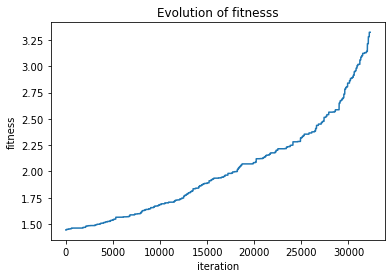

In [14]:
plot_history(history)

## Run PSO for funds

In [15]:
FundsPSO = ParticleSwarmOptimizer(
    population_size=PSO_POPULATION,
    hyperparameters=PSO_HP,
    constraints=PSOConstraints(
        n_var = len(fund_data),
        var_min = 0.02,
        var_max = 0.20,
        min_diff_titles = 8,
    ),
    day_count=1093,
    beg_values=list2beg(fund_data),
    end_values=list2end(fund_data),
    cov=list2cov(fund_data),
)

In [16]:
best_funds_particle, history = FundsPSO.run(PSO_NB_ITER)

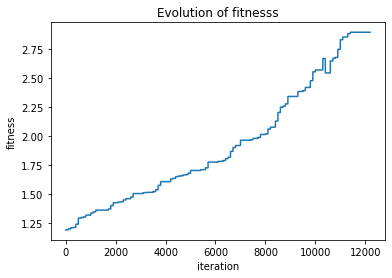

In [17]:
plot_history(history)

# Construct complete portfolio

In [18]:
best_particle = np.concatenate((best_funds_particle*0.49, best_stock_particle*0.51))

#### Check if constraints are respected

In [19]:
check_constraints(best_particle, len(fund_data))

[OK] Stock %: 0.51
[OK] %Nav
[OK] Asset count: 18


### Compute total fitness

In [20]:
TestPSO = ParticleSwarmOptimizer(
    population_size=0,
    hyperparameters=PSO_HP,
    constraints=PSOConstraints(
        n_var = len(all_data),
        var_min = 0.02,
        var_max = 0.20,
        min_diff_titles = 8,
    ),
    day_count=1093,
    beg_values=list2beg(all_data),
    end_values=list2end(all_data),
    cov=list2cov(all_data),
)
TestPSO.fitness(best_particle)

3.0042482169412263

# Compute final portfolio

In [21]:
prices = np.array([v.price for v in all_data])

In [22]:
def nav_to_count(total, prices, nav):
    return ((total * nav) / prices).astype(np.int32)

def count_to_nav(total, prices, count):
    return (count * prices) / total

def price_error(total, prices, nav):
    diff = nav - count_to_nav(total, prices, nav_to_count(total, prices, nav))
    return np.sum(np.abs(diff))

total_price = 100000

while price_error(total_price, prices, best_particle) > 0.001:
    total_price *= 2

portfolio_titles = nav_to_count(total_price, prices, best_particle).astype(np.int32)
f"{total_price:,}$"

'25,600,000$'

### Let's check if the approximation was successful

In [23]:
final_particle = count_to_nav(total_price, prices, portfolio_titles)
np.max(np.abs(final_particle - best_particle))

0.0003774591061593627

In [24]:
TestPSO.fitness(final_particle)

3.0032661509398517

In [25]:
check_constraints(final_particle, len(fund_data))

[OK] Stock %: 0.51
[OK] %Nav
[OK] Asset count: 18


### Compute real portfolio

In [26]:
# funds decimalisation
final_portfolio_counts = portfolio_titles

# back to IDs!
final_portfolio = {}
keys = [v.key for v in all_data]

for i, v in enumerate(final_portfolio_counts):
    if v == 0:
        continue

    asset = asset_dict[keys[i]]
    date = BEG_OF_TIME #str(first_returns[keys[i]])

    final_portfolio.setdefault(date, []).append({
        "asset": {
            "asset": int(keys[i]),
            "quantity": int(v),
        }
    })

final_portfolio

{'2016-06-01': [{'asset': {'asset': 2164, 'quantity': 28016}},
  {'asset': {'asset': 2165, 'quantity': 119}},
  {'asset': {'asset': 2174, 'quantity': 1041}},
  {'asset': {'asset': 1485, 'quantity': 12}},
  {'asset': {'asset': 1519, 'quantity': 11777}},
  {'asset': {'asset': 2190, 'quantity': 10966}},
  {'asset': {'asset': 1616, 'quantity': 1008}},
  {'asset': {'asset': 2161, 'quantity': 27232}},
  {'asset': {'asset': 2195, 'quantity': 706}},
  {'asset': {'asset': 1870, 'quantity': 206497}},
  {'asset': {'asset': 1910, 'quantity': 33477}},
  {'asset': {'asset': 1913, 'quantity': 27552}},
  {'asset': {'asset': 1925, 'quantity': 73429}},
  {'asset': {'asset': 1961, 'quantity': 55529}},
  {'asset': {'asset': 1988, 'quantity': 12960}},
  {'asset': {'asset': 1998, 'quantity': 178410}},
  {'asset': {'asset': 2024, 'quantity': 21606}},
  {'asset': {'asset': 2023, 'quantity': 3727758}}]}

# Upload portfolio

In [27]:
portfolio_obj = {
    "label": "EPITA_PTF_1",
    "currency": {
        "code": "EUR"
    },
    "type": "front",
    "values": final_portfolio,
}

# Do it two times because the API is broken
Jump().update_portfolio(our_portfolio.key, portfolio_obj)
Jump().update_portfolio(our_portfolio.key, portfolio_obj)

<Response [200]>

### Check sharp ratio

In [28]:
results = Jump().calculate_ratio(ratio_ids=[12], asset_ids=[our_portfolio.key, ref_portfolio.key]).json()

print("Local ratio:", TestPSO.fitness(final_particle))
print("Jump  ratio:", results[our_portfolio.key]['12']['value'])
print("Ref   ratio:", results[ref_portfolio.key]['12']['value'])

Local ratio: 3.0032661509398517
Jump  ratio: 0,68415009153
Ref   ratio: 0,146571943186


In [29]:
Jump().calculate_ratio(ratio_ids=[13, 9, 12, 10], asset_ids=[our_portfolio.key]).json()

{'1820': {'13': {'type': 'percent', 'value': '5,923445508066'},
  '9': {'type': 'percent', 'value': '0,562273945245'},
  '12': {'type': 'double', 'value': '0,68415009153'},
  '10': {'type': 'percent', 'value': '0,814549251904'}}}

In [30]:
# ok
A = np.array([v.first_nav for v in all_data])
B = np.array([v.navs[-1] for v in all_data])

S = np.sum(B * (best_particle / A))
S = S ** (252/1093) - 1
S

0.5622842271023101

In [31]:
all_navs = np.array([v.navs for v in all_data])
all_navs.shape

(461, 1583)

1583

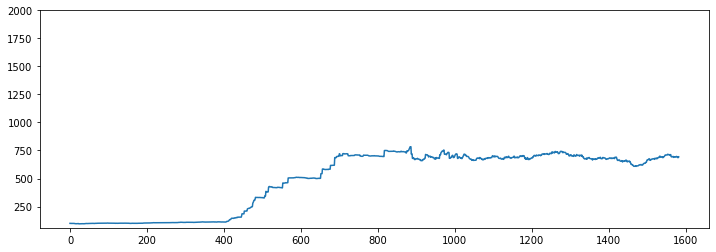

In [43]:
#nav = np.sum(best_particle * all_navs.T, axis=1)
nav = (100 * best_particle / all_navs.T[0]) @ all_navs
returns = np.diff(nav) / nav[:-1]
plt.figure(figsize = (12, 4))
plt.plot(nav)
plt.ylim(top=2000)
len(nav)

In [33]:
np.std(returns) * np.sqrt(252)

0.1854400922343578

In [58]:
from importlib import reload  
import src.jump
reload(src.jump)
from src.jump import Jump

In [59]:
ref_v = Jump().get_asset(asset_dict[our_portfolio.key], our_portfolio.key)

(12.218129017707653, 2000.0)

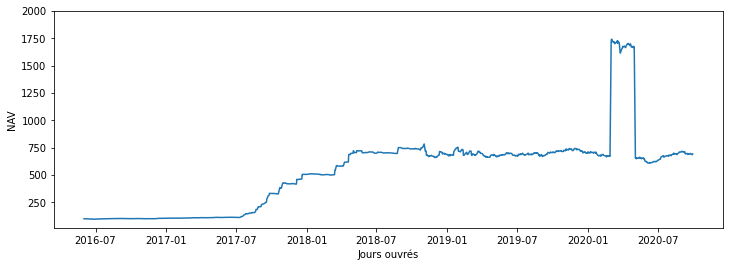

In [60]:
legend = []
a = []
for v in ref_v:
    legend.append(datetime.strptime(v["date"], '%Y-%m-%d').date())
    a.append(v["values_usd"]["nav"])

plt.figure(figsize = (12, 4))

plt.plot(legend, a)
plt.ylabel("NAV")
plt.xlabel("Jours ouvrés")
plt.ylim(top=2000)

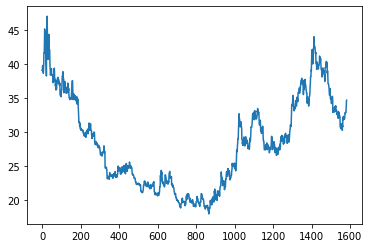

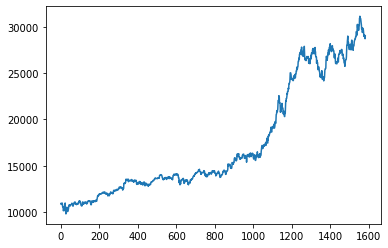

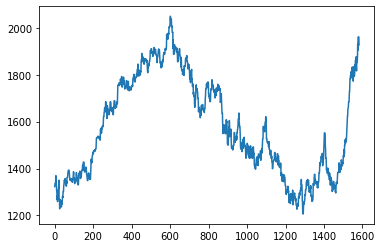

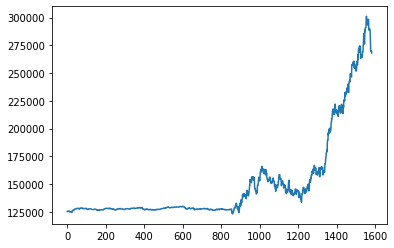

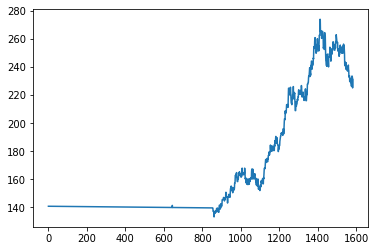

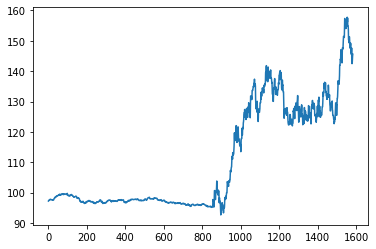

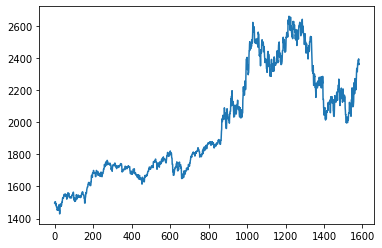

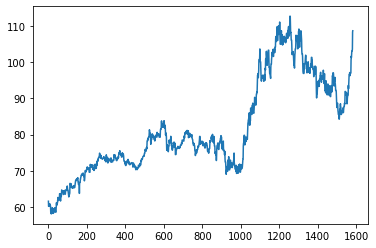

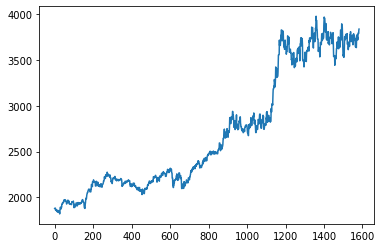

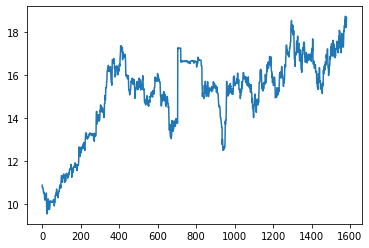

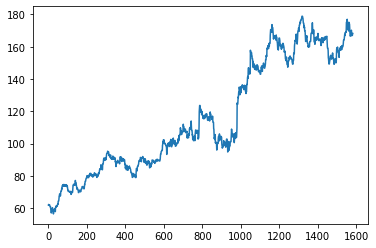

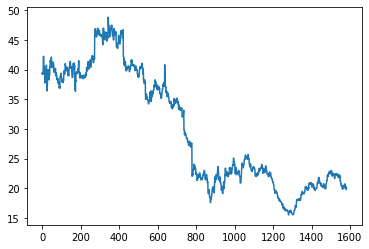

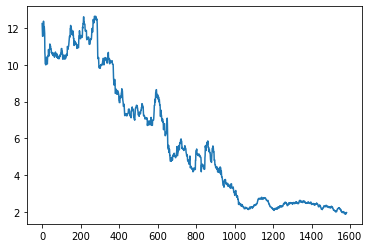

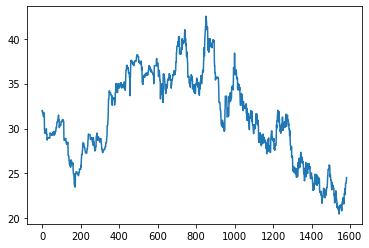

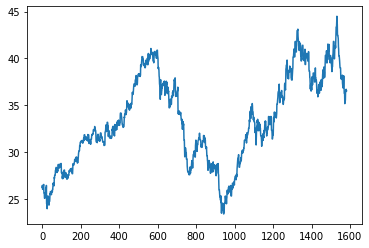

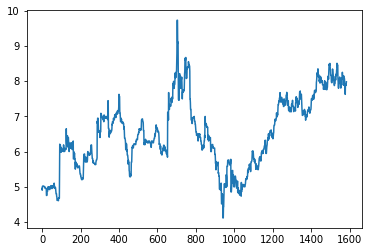

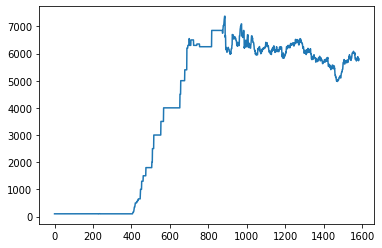

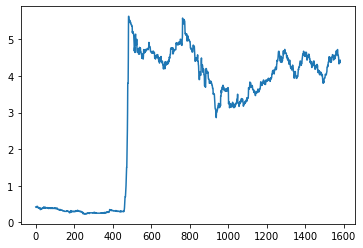

In [38]:
for v in final_portfolio["2016-06-01"]:
    key = v["asset"]["asset"]
    asset = [v for v in all_data if v.key == str(key)]
    
    plt.figure()
    plt.plot(asset[0].navs)

In [81]:
ref_v[0]["values_usd"]

{'nav': 99.48477869293, 'gross': 5705838.37998542, 'close': 0.0}

In [39]:
ref_v[0]

{'date': '2016-06-01',
 'pl': -18633.0292829428,
 'return': -0.000812566662,
 'original_currency': 'USD',
 'converted': False,
 'values': {'nav': 99.91874333384, 'gross': 22912444.706775766, 'close': 0.0},
 'values_usd': {'nav': 99.91874333384,
  'gross': 22912444.706775766,
  'close': 0.0}}

In [77]:
Jump().get_portfolio(our_portfolio.key)

{'label': 'EPITA_PTF_1',
 'currency': {'code': 'USD'},
 'type': 'front',
 'values': {'2016-06-01': [{'asset': {'asset': 1509, 'quantity': 2273.0}},
   {'asset': {'asset': 1541, 'quantity': 43.0}},
   {'asset': {'asset': 2152, 'quantity': 1109.0}},
   {'asset': {'asset': 1928, 'quantity': 511.0}},
   {'asset': {'asset': 2024, 'quantity': 4501.0}},
   {'asset': {'asset': 2154, 'quantity': 29302.0}},
   {'asset': {'asset': 1994, 'quantity': 6201.0}},
   {'asset': {'asset': 1934, 'quantity': 3111.0}},
   {'asset': {'asset': 1455, 'quantity': 2593.0}},
   {'asset': {'asset': 2160, 'quantity': 5869.0}},
   {'asset': {'asset': 2032, 'quantity': 830.0}},
   {'asset': {'asset': 1458, 'quantity': 27133.0}},
   {'asset': {'asset': 2067, 'quantity': 562.0}},
   {'asset': {'asset': 1875, 'quantity': 9641.0}},
   {'asset': {'asset': 1845, 'quantity': 8410.0}},
   {'asset': {'asset': 1590, 'quantity': 16610.0}},
   {'asset': {'asset': 2139, 'quantity': 1340.0}},
   {'asset': {'asset': 1596, 'quantity